In [97]:
# Import libraries-----------------------------------------

# Dataframe Handling---------------------------------------
import pandas as pd
import numpy as np

# Data visualization---------------------------------------
import seaborn as sns

# Data Standardization-------------------------------------
from sklearn.preprocessing import StandardScaler

# ML models------------------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#!pip install xgboost
import xgboost as xgb

# Evaluation metrics---------------------------------------
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score

# Search the best model------------------------------------
from sklearn.model_selection import RandomizedSearchCV

# Train Test Split
from sklearn.model_selection import train_test_split

# SMOTE technique to tackle imbalenced dataset
from imblearn.over_sampling import SMOTE

# Nivell 1

## Exercici 1

Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).

### Step 1 - Read, Explore, Treat and Prepare dataframe for modeling

In [3]:
df_flighs_delay = pd.read_csv('C:/Users/xizes/DelayedFlights.csv')

In [4]:
pd.set_option('display.max_columns', None)
df_flighs_delay.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [5]:
df_flighs_delay.shape

(1936758, 30)

In [6]:
# Drop columns that won´t be used as features
df_flighs_delay_drop = df_flighs_delay.drop(columns=['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'CRSElapsedTime', 'Origin', 'Dest', 'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
                                                     'LateAircraftDelay'])

In [7]:
# Since our problem is a classification one and the df does not have a categorical column indicating delayed or not delayed,
#I´ll create that column containg 0 for not delayed and 1 for delayed, based on the ArrDelay column
df_flighs_delay_drop['Delayed'] = np.where(df_flighs_delay_drop['ArrDelay'] <= 0, 0, 1)

In [8]:
df_flighs_delay_drop[['ArrDelay', 'Delayed']].head()

,ArrDelay,Delayed
0,-14.0,0
1,2.0,1
2,14.0,1
3,34.0,1
4,11.0,1


<AxesSubplot:xlabel='Delayed', ylabel='Delayed'>

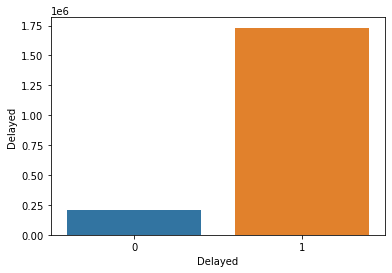

In [9]:
# Plot 'Delayed' class distribution
sns.barplot(data=df_flighs_delay_drop, x='Delayed', y=df_flighs_delay_drop['Delayed'].value_counts())

As we can see the dataframe is really imbalanced, what will probably mess with our predictions if we don´t treat it. 

We´ll handle this imbalance on the next exercises, so we can compare the results using the original, imbalanced, dataframe and the dataframe with some kind of treatment.

In [10]:
# Check how many NaN
df_flighs_delay_drop.isna().sum()

ActualElapsedTime    8387
AirTime              8387
ArrDelay             8387
DepDelay                0
Distance                0
TaxiIn               7110
TaxiOut               455
Cancelled               0
Diverted                0
Delayed                 0
dtype: int64

In [11]:
# Drop NaN
df_flighs_delay_drop_nonan = df_flighs_delay_drop.dropna()

In [12]:
# Since our column 'Delayed' is based on the 'ArrDelay', I´ll drop 'ArrDelay' as well
df_flighs_delay_drop_nonan.drop(columns=['ArrDelay'], inplace=True)

C:\Users\xizes\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
df_flighs_delay_drop_nonan.shape

(1928371, 9)

### Step 2 - Feature selection and data Standardization

In [14]:
#df_flighs_delay_drop_nonan.head()

In [15]:
# Feature selection
X = df_flighs_delay_drop_nonan.drop(columns=['Delayed'])
y = df_flighs_delay_drop_nonan['Delayed']

In [16]:
# Create StandardScaler object
std = StandardScaler()

In [17]:
# Standardize features
X_std = std.fit_transform(X)

In [18]:
X_std[:5]

array([[-0.07363114,  0.11250817, -0.65880113,  0.07850241, -0.53366771,
        -0.71408012,  0.        ,  0.        ],
       [-0.07363114,  0.06880353, -0.45229036,  0.07850241, -0.34384414,
        -0.57430187,  0.        ,  0.        ],
       [-0.51770521, -0.4702204 , -0.65880113, -0.4355373 , -0.72349129,
        -0.08507799,  0.        ,  0.        ],
       [-0.6009691 , -0.45565219, -0.17068477, -0.4355373 , -0.72349129,
        -0.57430187,  0.        ,  0.        ],
       [-0.44831863, -0.30997004, -0.33964813, -0.13408351, -0.53366771,
        -0.57430187,  0.        ,  0.        ]])

### Step 3 - Apply models

I´ll select 3 models and apply them on the original features (without standardization) and also on the standardized ones:
- Decision Tree Classifier
- KNN k-nearest neighbors
- XGBoost

### 3.1 - Decision Tree Classifier

In [19]:
dtree_classifier = DecisionTreeClassifier(max_depth=3, random_state=11)

#### 3.1.1 - Non-standardized features

In [20]:
dtree_classifier_nonstd = dtree_classifier.fit(X, y)

In [21]:
dtree_classifier_nonstd_pred = dtree_classifier_nonstd.predict(X)

#### 3.1.2 - Standardized features

In [22]:
dtree_classifier_std = dtree_classifier.fit(X_std, y)

In [23]:
dtree_classifier_std_pred = dtree_classifier_std.predict(X_std)

### 3.2 - KNN k-nearest neighbors

In [24]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

#### 3.2.1 - Non-standardized features

In [25]:
knn_classifier_nonstd = knn_classifier.fit(X, y)

In [26]:
knn_classifier_nonstd_pred = knn_classifier_nonstd.predict(X)

#### 3.2.2 - Standardized features

In [27]:
#knn_classifier_std = knn_classifier.fit(X_std, y)

### 3.3 - XGBoost Classifier

In [28]:
xgb_classifier = xgb.XGBClassifier()

#### 3.3.1 - Non-standardized features

In [29]:
xgb_classifier_nonstd = xgb_classifier.fit(X, y)

C:\Users\xizes\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
xgb_classifier_nonstd_pred = xgb_classifier_nonstd.predict(X)

#### 3.3.2 - Standardized features

In [31]:
xgb_classifier_std = xgb_classifier.fit(X_std, y)

[10:29:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
xgb_classifier_std_pred = xgb_classifier.predict(X_std)

## Exercici 2
Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.

**RESULTS USING ORIGINAL, UNBALANCED, DATAFRAME**

For this exercise we´ll use the classification report (that gives us precision, recall and f1-score) and the confusion matrix.

Quick review of concepts:

### Accuracy  
Shows how many of the predictions are correct. 

***!!Shortcoming!!***  
**If we have an unbalanced dataset the model will likely predict only the major class and the accuracy score doesn\`t allow us to see this.**

### Confusion Matrix  
The confusion matrix is a really important classification information, because it gives fast and easy insight about class imbalance and the general model behaviour.  

A confusion matrix is not a metric to evaluate a model, but it provides insight into the predictions. It shows the correct and incorrect (i.e. true or false) predictions on each class. 

In case of a binary classification task, a confusion matrix is a 2x2 matrix. If there are three different classes, it is a 3x3 matrix and so on.  

Sklearn´s convention of a confusion matrix is as follows:
![](confusion_matrix1.png)

### Precision  
Measures how good our model is when the prediction is positive. The focus of precision is positive predictions. It indicates how many positive predictions are true.

### Recall (or True Postive Rate or Sensitivity)  
When the actual value is positive, how often the prediction is correct?

### AUC (Area Under the Curve)  
If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation.  
AUC is usefull even when there is high class imbalance.


### 1 - Decision Tree Classifier

#### 1.1 - Non-standardized features

In [33]:
print(classification_report(y, dtree_classifier_nonstd_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    204956
           1       0.89      1.00      0.94   1723415

    accuracy                           0.89   1928371
   macro avg       0.45      0.50      0.47   1928371
weighted avg       0.80      0.89      0.84   1928371



In [34]:
confusion_matrix(y, dtree_classifier_nonstd_pred)

array([[      0,  204956],
       [      0, 1723415]], dtype=int64)

In [35]:
roc_auc_score(y, dtree_classifier_nonstd_pred)

0.5

#### 1.2 - Standardized features

In [36]:
print(classification_report(y, dtree_classifier_std_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    204956
           1       0.89      1.00      0.94   1723415

    accuracy                           0.89   1928371
   macro avg       0.45      0.50      0.47   1928371
weighted avg       0.80      0.89      0.84   1928371



In [37]:
confusion_matrix(y, dtree_classifier_std_pred)

array([[      0,  204956],
       [      0, 1723415]], dtype=int64)

### 2 - KNN k-nearest neighbors

#### 2.1 - Non-standardized features

#### 2.2 - Non-standardized features

In [38]:
print(classification_report(y, knn_classifier_nonstd_pred))

              precision    recall  f1-score   support

           0       0.78      0.61      0.68    204956
           1       0.95      0.98      0.97   1723415

    accuracy                           0.94   1928371
   macro avg       0.87      0.80      0.83   1928371
weighted avg       0.94      0.94      0.94   1928371



In [39]:
confusion_matrix(y, knn_classifier_nonstd_pred)

array([[ 125359,   79597],
       [  36316, 1687099]], dtype=int64)

In [40]:
roc_auc_score(y, knn_classifier_nonstd_pred)

0.7952832400314811

### 3 - XGBoost

#### 3.1 - Non-standardized features

In [41]:
print(classification_report(y, xgb_classifier_nonstd_pred))

              precision    recall  f1-score   support

           0       0.71      0.44      0.54    204956
           1       0.94      0.98      0.96   1723415

    accuracy                           0.92   1928371
   macro avg       0.82      0.71      0.75   1928371
weighted avg       0.91      0.92      0.91   1928371



In [42]:
confusion_matrix(y, xgb_classifier_nonstd_pred)

array([[  90812,  114144],
       [  37924, 1685491]], dtype=int64)

In [43]:
roc_auc_score(y, xgb_classifier_nonstd_pred)

0.7105376596466072

#### 3.2 - Standardized features

In [44]:
print(classification_report(y, xgb_classifier_std_pred))

              precision    recall  f1-score   support

           0       0.71      0.44      0.54    204956
           1       0.94      0.98      0.96   1723415

    accuracy                           0.92   1928371
   macro avg       0.82      0.71      0.75   1928371
weighted avg       0.91      0.92      0.91   1928371



In [45]:
confusion_matrix(y, xgb_classifier_std_pred)

array([[  90812,  114144],
       [  37924, 1685491]], dtype=int64)

**Observations:**  
**1) There was no difference between the results using the non-standardized and standardized features.**  
**2) The Decision Tree Classifier returned really bad results.**

## Exercici 3
Entrena’ls utilitzant els diferents paràmetres que admeten.

**For this exercise I´ll use Randomized Search CV in order to automatize the search for the best model.**

###  1 - Decision Tree Classifier

In [46]:
classifier_dtree = DecisionTreeClassifier()
param_distributions_dtree = dict(criterion=['gini', 'entropy'],
                           splitter=['best', 'random'],
                           max_depth=[3, 4, 5, 6],
                           max_features=[None, 'auto', 'sqrt', 'log2'],
                           )

In [47]:
classifier_random_dtree = RandomizedSearchCV(estimator=classifier_dtree, 
                   param_distributions=param_distributions_dtree, 
                   n_iter=10, 
                   scoring='accuracy',
                   cv=10,
                   random_state=11)

In [48]:
classifier_random_dtree.fit(X, y)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 6],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'splitter': ['best', 'random']},
                   random_state=11, scoring='accuracy')

In [49]:
print (classifier_random_dtree.best_estimator_)
print (classifier_random_dtree.best_params_)
print (classifier_random_dtree.best_score_)

DecisionTreeClassifier(max_depth=6, max_features='auto')
{'splitter': 'best', 'max_features': 'auto', 'max_depth': 6, 'criterion': 'gini'}
0.8963845650786257


In [50]:
classifier_random_dtree_pred = classifier_random_dtree.predict(X)

In [96]:
print(classification_report(y, classifier_random_dtree_pred, zero_division=0))
print()
print(confusion_matrix(y, classifier_random_dtree_pred))
print()
print(roc_auc_score(y, classifier_random_dtree_pred))

              precision    recall  f1-score   support

           0       0.57      0.23      0.33    204956
           1       0.91      0.98      0.95   1723415

    accuracy                           0.90   1928371
   macro avg       0.74      0.60      0.64   1928371
weighted avg       0.88      0.90      0.88   1928371


[[  47123  157833]
 [  35234 1688181]]

0.6047366742838718


As we can see we got better results than the simplified first model we did above.

### 2 - KNN k-nearest neighbors

In [61]:
classifier_knn = KNeighborsClassifier()
param_distributions_knn = dict(algorithm=['auto','brute'],
                               n_neighbors=[3,5],
                               weights=['uniform'])

In [64]:
classifier_random_knn = RandomizedSearchCV(estimator=classifier_knn, 
                                           param_distributions=param_distributions_knn,
                                           n_iter=5,
                                           scoring='accuracy',
                                           cv=2,
                                           random_state=11)

In [69]:
# Since on all the other iterations my pc couldn´t finish the fitting processs, 
#even with a diminute params_distributions, I decided to use a sample of the dataset to follow with the exercise.
df_flights_sample = df_flighs_delay_drop_nonan.sample(n=100000)

X_sample = df_flights_sample.drop(columns=['Delayed'])
y_sample = df_flights_sample['Delayed']

In [70]:
classifier_random_knn.fit(X_sample, y_sample)

C:\Users\xizes\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=2, estimator=KNeighborsClassifier(), n_iter=5,
                   param_distributions={'algorithm': ['auto', 'brute'],
                                        'n_neighbors': [3, 5],
                                        'weights': ['uniform']},
                   random_state=11, scoring='accuracy')

In [71]:
print (classifier_random_knn.best_estimator_)
print (classifier_random_knn.best_params_)
print (classifier_random_knn.best_score_)

KNeighborsClassifier(algorithm='brute')
{'weights': 'uniform', 'n_neighbors': 5, 'algorithm': 'brute'}
0.90575


In [73]:
classifier_random_knn_pred = classifier_random_knn.predict(X_sample)

In [95]:
print(classification_report(y_sample, classifier_random_knn_pred))
print()
print(confusion_matrix(y_sample, classifier_random_knn_pred))
print()
print(roc_auc_score(y_sample, classifier_random_knn_pred))

              precision    recall  f1-score   support

           0       0.76      0.56      0.65     10621
           1       0.95      0.98      0.96     89379

    accuracy                           0.93    100000
   macro avg       0.85      0.77      0.80    100000
weighted avg       0.93      0.93      0.93    100000


[[ 5966  4655]
 [ 1891 87488]]

0.7702801286739765


## Exercici 4
Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation.

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### 1 - Decision Tree Classifier

In [80]:
classifier_dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [81]:
classifier_dtree_pred = classifier_dtree.predict(X_test)

In [91]:
print(classification_report(y_test, classifier_dtree_pred))
print()
print(confusion_matrix(y_test, classifier_dtree_pred))
print()
print(roc_auc_score(y_test, classifier_dtree_pred))

              precision    recall  f1-score   support

           0       0.48      0.51      0.49     40724
           1       0.94      0.94      0.94    344951

    accuracy                           0.89    385675
   macro avg       0.71      0.72      0.72    385675
weighted avg       0.89      0.89      0.89    385675


[[ 20652  20072]
 [ 22414 322537]]

0.7210718816689048


### 2 - KNN k-nearest neighbors

In [92]:
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [93]:
knn_classifier_pred = knn_classifier.predict(X_test)

In [98]:
print(classification_report(y_test, knn_classifier_pred))
print()
print(confusion_matrix(y_test, knn_classifier_pred))
print()
print(roc_auc_score(y_test, knn_classifier_pred))

              precision    recall  f1-score   support

           0       0.63      0.49      0.55     40724
           1       0.94      0.97      0.95    344951

    accuracy                           0.92    385675
   macro avg       0.79      0.73      0.75    385675
weighted avg       0.91      0.92      0.91    385675


[[ 19863  20861]
 [ 11644 333307]]

0.7269956321619331


# Nivell 2

## Exercici 5
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

**I´ll use the SMOTE technique to adress the imbalance problem of the dataset**

In [99]:
sm = SMOTE()

In [100]:
X_sm, y_sm = sm.fit_resample(X, y)

In [104]:
# Show X and y shapes before and after resampling
print(f'X before SMOTE: {X.shape}, X after SMOTE: {X_sm.shape}')
print(f'y before SMOTE: {y.shape}, y after SMOTE: {y_sm.shape}')

X before SMOTE: (1928371, 8), X after SMOTE: (3446830, 8)
y before SMOTE: (1928371,), y after SMOTE: (3446830,)


<AxesSubplot:ylabel='Delayed'>

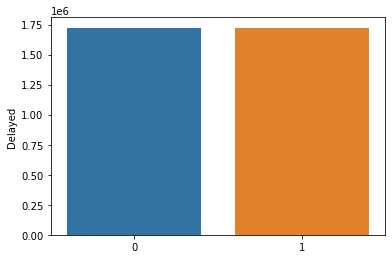

In [110]:
# Plot class distribution after SMOTE technique
sns.barplot(x=y_sm.unique(), y=y_sm.value_counts())

As we can see, now our dataset is balanced between the two classes.

### After SMOTE I´ll repeat Randomized CV with Decision Tree and KNN

In [113]:
# Apply train_test after the SMOTE technique
#X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.2)

### 1 - Decision Tree Classifier

In [127]:
classifier_random_dtree_smote = RandomizedSearchCV(estimator=classifier_dtree,
                                                   param_distributions=param_distributions_dtree,
                                                   n_iter=5,
                                                   cv=5,
                                                   scoring='roc_auc')

In [128]:
classifier_random_dtree_smote.fit(X_sm, y_sm)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 6],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'splitter': ['best', 'random']},
                   scoring='roc_auc')

In [129]:
#from sklearn.metrics import SCORERS
#SCORERS.keys()

In [139]:
classifier_random_dtree_smote.best_params_

{'splitter': 'best', 'max_features': None, 'max_depth': 3, 'criterion': 'gini'}

In [117]:
classifier_random_dtree_smote_pred = classifier_random_dtree_smote.predict(X_sm)

In [140]:
print(classification_report(y_sm, classifier_random_dtree_smote_pred))
print()
print(confusion_matrix(y_sm, classifier_random_dtree_smote_pred))
print()
print(roc_auc_score(y_sm, classifier_random_dtree_smote_pred))
print()
print(accuracy_score(y_sm, classifier_random_dtree_smote_pred))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84   1723415
           1       0.91      0.71      0.80   1723415

    accuracy                           0.82   3446830
   macro avg       0.84      0.82      0.82   3446830
weighted avg       0.84      0.82      0.82   3446830


[[1604817  118598]
 [ 496414 1227001]]

0.8215717050159131

0.8215717050159131


### 2 - KNN k-nearest neighbors

In [142]:
# Again, I´ll use a sample of the dataset because of processing time
X_sm_sample, y_sm_sample = sm.fit_resample(X_sample, y_sample)

In [143]:
classifier_random_knn_smote = classifier_random_knn.fit(X_sm_sample, y_sm_sample)

C:\Users\xizes\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [144]:
classifier_random_knn_smote.best_params_

{'weights': 'uniform', 'n_neighbors': 3, 'algorithm': 'brute'}

In [145]:
classifier_random_knn_smote_pred = classifier_random_knn_smote.predict(X_sm_sample)

In [146]:
print(classification_report(y_sm_sample, classifier_random_knn_smote_pred))
print()
print(confusion_matrix(y_sm_sample, classifier_random_knn_smote_pred))
print()
print(roc_auc_score(y_sm_sample, classifier_random_knn_smote_pred))
print()
print(accuracy_score(y_sm_sample, classifier_random_knn_smote_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     89379
           1       1.00      0.92      0.96     89379

    accuracy                           0.96    178758
   macro avg       0.96      0.96      0.96    178758
weighted avg       0.96      0.96      0.96    178758


[[89114   265]
 [ 7111 82268]]

0.9587375110484566

0.9587375110484566


# Nivell 3

## Exercici 6
No utilitzis la variable DepDelay a l’hora de fer prediccions

In [147]:
# Quit 'DepDelay' column
df_flighs_delay_drop_nonan_nodep = df_flighs_delay_drop_nonan.drop(columns=['DepDelay'])

# Alternative dataset to be used with KNN algorithym
df_flighs_delay_drop_nonan_nodep

In [148]:
# Feature selection
X = df_flighs_delay_drop_nonan_nodep.drop(columns=['Delayed'])
y = df_flighs_delay_drop_nonan_nodep['Delayed']

**SMOTE**

In [150]:
X_sm, y_sm = sm.fit_resample(X, y)

**Train_Test_Split**

In [154]:
# I´ll spare 15% of the full dataset, with train test split, before doing Randomized Search CV again.
# The idea is to test the trained model on unseen data
X_sm_train, X_sm_test, y_sm_train, y_sm_test = train_test_split(X_sm, y_sm, test_size=0.15, random_state=11)

### 1 - Decision Tree 

In [155]:
classifier_random_dtree.fit(X_sm_train, y_sm_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 6],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'splitter': ['best', 'random']},
                   random_state=11, scoring='accuracy')

In [156]:
classifier_random_dtree_pred = classifier_random_dtree.predict(X_sm_test)

In [158]:
print(classification_report(y_sm_test, classifier_random_dtree_pred))
print()
print(confusion_matrix(y_sm_test, classifier_random_dtree_pred))
print()
print(roc_auc_score(y_sm_test, classifier_random_dtree_pred))
print()
print(accuracy_score(y_sm_test, classifier_random_dtree_pred))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66    257944
           1       0.66      0.68      0.67    259081

    accuracy                           0.67    517025
   macro avg       0.67      0.67      0.67    517025
weighted avg       0.67      0.67      0.67    517025


[[168811  89133]
 [ 83069 176012]]

0.6669093983404873

0.6669368018954596


**Since already on the first algorithym we can see that the performance is much worse when we drop 'DepDelay' column I´ll stop here.**